In [138]:
import numpy as np
def polygonize(lengths):
    '''
    Returns coordinates for the polygon vertexes used in cyclical TS construction,
    as a list of vector couples specifying starting and ending point of each pivot 
    vector. For bimolecular TSs, returns vertexes for the centered superposition of
    two segments. For trimolecular TSs, returns triangle vertexes.

    :params vertexes: list of floats, used as polygon side lenghts.
    :return vertexes_out: list of vectors couples (start, end)
    '''
    assert len(lengths) in (2,3)
    lengths = sorted(lengths)
    arr = np.zeros((len(lengths),2,3))

    if len(lengths) == 2:
        arr[0,0] = np.array([-lengths[0]/2,0,0])
        arr[0,1] = np.array([+lengths[0]/2,0,0])
        arr[1,0] = np.array([-lengths[1]/2,0,0])
        arr[1,1] = np.array([+lengths[1]/2,0,0])

        vertexes_out = np.vstack(([arr],[arr]))
        vertexes_out[1,1] *= -1
        # THIS WORKS

    else:
        arr[0,1] = np.array([lengths[0],0,0])
        arr[1,0] = np.array([lengths[0],0,0])

        a = np.power(lengths[0], 2)
        b = np.power(lengths[1], 2)
        c = np.power(lengths[2], 2)
        x = (a-b+c)/(2*a**0.5)
        y = (c-x**2)**0.5

        arr[1,1] = np.array([x,y,0])
        arr[2,0] = np.array([x,y,0])

        vertexes_out = np.vstack(([arr],[arr],[arr],[arr],
                                  [arr],[arr],[arr],[arr]))

        swaps = [(1,2),(2,1),(3,1),(3,2),(4,0),(5,0),(5,1),(6,0),(6,2),(7,0),(7,1),(7,2)]

        for t,v in swaps:
            # triangle, vector couples to be swapped
            vertexes_out[t,v][[0,1]] = vertexes_out[t,v][[1,0]]

    return vertexes_out

In [141]:
w = polygonize([3,4,5])

In [140]:
# for vecs in polygonize([3,4]):
#     for start, end in vecs:
#         print(np.linalg.norm(start-end))
#     print()

for vecs in polygonize([3,4,5]):
    for start, end in vecs:
        print(np.linalg.norm(start-end))
    print()

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0

3.0
4.0
5.0



In [109]:
arr = np.array([3,2])
np.power(np.sum(arr**2), 0.5)

3.605551275463989

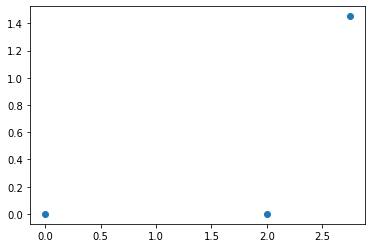

In [21]:
import matplotlib.pyplot as plt
l = [4,3,2]
vecs = polygonize(l)
x = [v[0,0] for v in vecs]
y = [v[0,1] for v in vecs]

fig = plt.figure()
plot = plt.plot(x,y,'o')
plt.show()

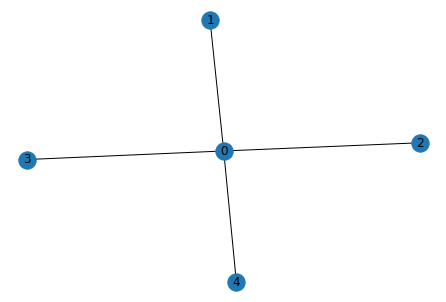

In [3]:
import networkx as nx
from hypermolecule_class import Hypermolecule

mol = Hypermolecule('Resources/SN2/CH3Br_ensemble.xyz', 0)
labels_dict = {i:i for i, n in enumerate(mol.atomnos)}
nx.draw(mol.graph, labels=labels_dict)

In [4]:
bonds = [(a, b) for a, b in list(mol.graph.edges) if a != b]
bonds

[(0, 1), (0, 2), (0, 3), (0, 4)]

In [12]:
from ase import Atoms
from ase.visualize import view
from ase.optimize import BFGS
from ase.constraints import FixBondLength, Hookean
from ase.calculators.gaussian import Gaussian
from cclib.io import ccread
from hypermolecule_class import pt
import os, time

def Hookean_optimization(TS_structure, TS_atomnos, constrained_indexes, mols_graphs, method='UFF'):
    '''
    Performs a geometry partial optimization (POPT) with Gaussian at $method level, 
    constraining the distance between the specified atom pair. Moreover, it includes a
    Hookean set of constraints to preserve molecular identities and prevent atom scrambling.

    :params TS_structure: list of coordinates for each atom in the TS
    :params TS_atomnos: list of atomic numbers for each atom in the TS
    :params constrained_indexes: indexes of constrained atoms in the TS geometry
    :params mols_graphs: list of molecule.graph objects, containing connectivity information
    :params mols_atomnos: list of molecule.atomnos lists, containing atomic number for all atoms
    :params method: Level of theory to be used in geometry optimization. Default if UFF.

    :return opt_struct: optimized structure
    '''
    assert len(constrained_indexes) == 2
    assert len(TS_structure) == sum([len(graph.nodes) for graph in mols_graphs])

    atoms = Atoms(''.join([pt[i].symbol for i in TS_atomnos]), positions=TS_structure)

    # atoms.edit()
    constraints = []
    constraints.append(FixBondLength(*constrained_indexes))
    print(f'Constrained indexes are {constrained_indexes}')

    rt_dict = {'CH':1.59} # Distance above which Hookean correction kicks in, in Angstroms
    k_dict  = {'CH':7}    # Spring force constant, in eV/Angstrom^2

    bonds = []
    for i, graph in enumerate(mols_graphs):

        pos = 0
        while i != 0:
            pos += len(mols_graphs[i-1].nodes)
            i -= 1

        for bond in [(a+pos, b+pos) for a, b in list(graph.edges) if a != b]:
            bonds.append(bond)
    # creating bond list containing all bonds present in the desired transition state

    i = 0
    for bond_a, bond_b in bonds:
        key = ''.join(sorted([pt[TS_atomnos[bond_a]].symbol, pt[TS_atomnos[bond_b]].symbol]))
        try:
            rt = rt_dict[key]
            k = k_dict[key]
            constraints.append(Hookean(a1=bond_a, a2=bond_b, rt=rt, k=k))
            i += 1
        except:
            pass
    print(f'Hookean-protected {i} CH bonds')

    atoms.set_constraint(constraints)
    # print('Constraints are', atoms.constraints)

    jobname = 'temp'
    atoms.calc = Gaussian(label=jobname, command=f'g09 {jobname}.com {jobname}.log', method='UFF')
    opt = BFGS(atoms, trajectory=f'{jobname}.traj', logfile=f'{jobname}.traj_log')

    t_start = time.time()

    try:
        opt.run(fmax=0.05)
    except Exception as e:
        print(e)

    t_end = time.time()

    print('Total time', round(t_end-t_start, 3), 's')

    view(atoms)

    return atoms.positions, atoms.get_total_energy

In [13]:
os.chdir(r'C:\Users\Nik\Desktop\Coding\TSCoDe')

mol1 = Hypermolecule('Resources/indole/indole_ensemble.xyz', 6)
mol2 = Hypermolecule('Resources/SN2/ketone_ensemble.xyz', 2)

TS = ccread('mopac_tests/TS_out.xyz')

Hookean_optimization(TS.atomcoords[0], TS.atomnos, [6,2+len(mol1.atomnos)], [mol1.graph, mol2.graph], method='UFF')

Constrained indexes are [6, 18]
Hookean-protected 14 CH bonds
Constraints are [<ase.constraints.FixBondLengths object at 0x000002681E7D5E10>, Hookean(0, 9), Hookean(1, 10), Hookean(4, 11), Hookean(5, 12), Hookean(6, 13), Hookean(7, 14), Hookean(16, 23), Hookean(16, 24), Hookean(17, 25), Hookean(18, 26), Hookean(19, 27), Hookean(22, 28), Hookean(22, 29), Hookean(22, 30)]
Total time 28.01 s


In [ ]:
def polygonize(lengths):
    '''
    '''
    assert lengths <

In [3]:
s = '      1          1  C    CARTESIAN X    -0.707459      0.727992  KCAL/ANGSTROM'
s.split()

['1', '1', 'C', 'CARTESIAN', 'X', '-0.707459', '0.727992', 'KCAL/ANGSTROM']

In [9]:
import numpy as np
arr = np.array([12,34,23,45,1,6,4,5,3,45])
msk = arr > 10
arr[msk]

array([12, 34, 23, 45, 45])

In [15]:
x = np.arange(5)*3
x[mask]

array([ 3,  6, 12])

In [48]:
# np.vstack((np.array([0,0,0]) for _ in range(2)))
a = np.array([1,1,1])
np.vstack((a for _ in range(3)))

C:\Users\ehrma\miniconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])